# ResNet18 finetuning convergence test

## Prerequisite: start the cluster

To use this notebook, we need an A100 VM and a TPU v5litepod-8 VM.
Both VMs should be reachable via IP address to each other.
This notebook is run on the A100 VM, which is also the ray head node.

Starting the head node:

```sh
ray start --head --port=6379
```

Joining the ray cluster from the TPU VM:

```sh
ray start --address=$GPU_IP:6379
```

In [1]:
import ray

ray.init()

2025-05-01 01:34:01,796	INFO worker.py:1660 -- Connecting to existing Ray cluster at address: 10.128.0.32:6379...
2025-05-01 01:34:01,812	INFO worker.py:1843 -- Connected to Ray cluster. View the dashboard at 127.0.0.1:8265 


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.10.14', ray_version='2.44.1', ray_commit='daca7b2b1a950dc7f731e34e74c76ae383794ffe')

(TpuResNetWorker pid=3232709, ip=10.138.0.2) WARNING:root:libtpu.so and TPU device found. Setting PJRT_DEVICE=TPU.


(pid=, ip=10.138.0.2) Log file created at: 2025/04/30 18:35:22
(pid=, ip=10.138.0.2) Running on machine: t1v-n-8ed780ed-w-0
(pid=, ip=10.138.0.2) Binary: Built on Jan 24 2025 17:49:30 (1737769770)
(pid=, ip=10.138.0.2) Binary: Built at cloud-tpus-runtime-release-tool@lmbco37.prod.google.com:/google/src/cloud/buildrabbit-username/buildrabbit-client/g3     
(pid=, ip=10.138.0.2) Binary: Built for gcc-4.X.Y-crosstool-v18-llvm-grtev4-k8.k8
(pid=, ip=10.138.0.2) Log line format: [IWEF]mmdd hh:mm:ss.uuuuuu threadid file:line] msg
(pid=, ip=10.138.0.2) I0430 18:35:22.764773 3232709 b295d63588a.cc:733] Linux version 6.5.0-1013-gcp (buildd@lcy02-amd64-064) (x86_64-linux-gnu-gcc-12 (Ubuntu 12.3.0-1ubuntu1~22.04) 12.3.0, GNU ld (GNU Binutils for Ubuntu) 2.38) #13~22.04.1-Ubuntu SMP Wed Jan 24 23:39:40 UTC 2024
(pid=, ip=10.138.0.2) I0430 18:35:22.774478 3232709 b295d63588a.cc:815] Process id 3232709
(pid=, ip=10.138.0.2) I0430 18:35:22.774493 3232709 b295d63588a.cc:820] Current working directory 

(TpuResNetWorker pid=3894085, ip=10.138.0.2) WARNING:root:libtpu.so and TPU device found. Setting PJRT_DEVICE=TPU.


(pid=, ip=10.138.0.2) Log file created at: 2025/04/30 21:02:19
(pid=, ip=10.138.0.2) Running on machine: t1v-n-8ed780ed-w-0
(pid=, ip=10.138.0.2) Binary: Built on Jan 24 2025 17:49:30 (1737769770)
(pid=, ip=10.138.0.2) Binary: Built at cloud-tpus-runtime-release-tool@lmbco37.prod.google.com:/google/src/cloud/buildrabbit-username/buildrabbit-client/g3     
(pid=, ip=10.138.0.2) Binary: Built for gcc-4.X.Y-crosstool-v18-llvm-grtev4-k8.k8
(pid=, ip=10.138.0.2) Log line format: [IWEF]mmdd hh:mm:ss.uuuuuu threadid file:line] msg
(pid=, ip=10.138.0.2) I0430 21:02:19.032793 3894085 b295d63588a.cc:733] Linux version 6.5.0-1013-gcp (buildd@lcy02-amd64-064) (x86_64-linux-gnu-gcc-12 (Ubuntu 12.3.0-1ubuntu1~22.04) 12.3.0, GNU ld (GNU Binutils for Ubuntu) 2.38) #13~22.04.1-Ubuntu SMP Wed Jan 24 23:39:40 UTC 2024
(pid=, ip=10.138.0.2) I0430 21:02:19.042521 3894085 b295d63588a.cc:815] Process id 3894085
(pid=, ip=10.138.0.2) I0430 21:02:19.042536 3894085 b295d63588a.cc:820] Current working directory 

(TpuResNetWorker pid=385284, ip=10.138.0.2) WARNING:root:libtpu.so and TPU device found. Setting PJRT_DEVICE=TPU.


(pid=, ip=10.138.0.2) Log file created at: 2025/04/30 23:31:02
(pid=, ip=10.138.0.2) Running on machine: t1v-n-8ed780ed-w-0
(pid=, ip=10.138.0.2) Binary: Built on Jan 24 2025 17:49:30 (1737769770)
(pid=, ip=10.138.0.2) Binary: Built at cloud-tpus-runtime-release-tool@lmbco37.prod.google.com:/google/src/cloud/buildrabbit-username/buildrabbit-client/g3     
(pid=, ip=10.138.0.2) Binary: Built for gcc-4.X.Y-crosstool-v18-llvm-grtev4-k8.k8
(pid=, ip=10.138.0.2) Log line format: [IWEF]mmdd hh:mm:ss.uuuuuu threadid file:line] msg
(pid=, ip=10.138.0.2) I0430 23:31:02.088845  385284 b295d63588a.cc:733] Linux version 6.5.0-1013-gcp (buildd@lcy02-amd64-064) (x86_64-linux-gnu-gcc-12 (Ubuntu 12.3.0-1ubuntu1~22.04) 12.3.0, GNU ld (GNU Binutils for Ubuntu) 2.38) #13~22.04.1-Ubuntu SMP Wed Jan 24 23:39:40 UTC 2024
(pid=, ip=10.138.0.2) I0430 23:31:02.161247  385284 b295d63588a.cc:815] Process id 385284
(pid=, ip=10.138.0.2) I0430 23:31:02.161263  385284 b295d63588a.cc:820] Current working directory /

In [2]:
import torch
import numpy as np
from torch.utils.data import DataLoader, default_collate
from torchvision import datasets, models, tv_tensors

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300

import random

np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

## Look at our training data

In [4]:
from datasets import load_dataset

def load_raw_dataset(split):
  dataset = load_dataset("flwrlabs/celeba", split=split, trust_remote_code=True, cache_dir='cache')
  return dataset.with_format("torch")

train = load_raw_dataset("train")
test = load_raw_dataset("test")
valid = load_raw_dataset("valid")

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/19 [00:00<?, ?it/s]

In [5]:
train_set = train.unique('celeb_id') # type: ignore
test_set = test.unique('celeb_id') # type: ignore
valid_set = valid.unique('celeb_id') # type: ignore
print(f"Train set: {len(train_set)}")
print(f"Test set: {len(test_set)}")
print(f"Valid set: {len(valid_set)}")
print(f"Total unique IDs: {len(set(train_set) | set(test_set) | set(valid_set))}")

Train set: 8192
Test set: 1000
Valid set: 985
Total unique IDs: 10177


Problem: there is no label overlap between train/test/valid sets.

We can't use the validation set to validate accuracy because it contains
completely unseen labels.

For the purpose of this specific convergence test, we'll do our own split
such that the same labels show up in both train and test sets.

In [6]:
from data_util import download_dataset_custom_split_cached

train_dataset, test_dataset, NUM_CLASSES = download_dataset_custom_split_cached()

Using cached datasets.
Number of classes: 10177
Train set size: 159267
Test set size: 43288


Number of classes: 10177
Train set size: 159267
Test set size: 43288


In [7]:
from tqdm import tqdm

train_loader = DataLoader(train_dataset, batch_size=64, num_workers=8, shuffle=False)  # type: ignore

# Enumerate train loader to find number of unique labels
train_unique_labels = set()
for batch in tqdm(train_loader):
    labels = batch['label']
    train_unique_labels.update(set(labels.flatten().numpy().tolist()))
print(f"Number of unique labels in train loader: {len(train_unique_labels)}")
# Enumerate test loader to find number of unique labels
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=8, shuffle=False)  # type: ignore
test_unique_labels = set()
for batch in tqdm(test_loader):
    labels = batch['label']
    test_unique_labels.update(set(labels.flatten().numpy().tolist()))
print(f"Number of unique labels in test loader: {len(test_unique_labels)}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2489/2489 [00:36<00:00, 68.10it/s]


Number of unique labels in train loader: 10133


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 677/677 [00:10<00:00, 66.16it/s]

Number of unique labels in test loader: 10133


In [8]:
NUM_CLASSES = max(train_unique_labels) + 1
print(f"Number of classes: {NUM_CLASSES}")
assert train_unique_labels == test_unique_labels

Number of classes: 10177


In [9]:
sorted(list(train_unique_labels))[-10:], sorted(list(test_unique_labels))[-10:]

([10167, 10168, 10169, 10170, 10171, 10172, 10173, 10174, 10175, 10176],
 [10167, 10168, 10169, 10170, 10171, 10172, 10173, 10174, 10175, 10176])

In [10]:
from actors import get_gpu_actor

gpu_actor = get_gpu_actor()
print(ray.get(gpu_actor.print_model_architecture.remote()))
print(ray.get(gpu_actor.get_cwd.remote()))

GPU Actor (PID: 3142287) using cuda (NVIDIA A100-SXM4-80GB)
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [11]:
# Utilities for convergence test
from tqdm import tqdm

def run_convergence_test(gpu_actor, tpu_actor, batch_size, training_split, dataloader_seed_mixer: int = 0):
  gpu_losses = []
  tpu_losses = []
  gpu_validation_metrics = []
  tpu_validation_metrics = []
  for epoch in range(40):
    gpu_stream = gpu_actor.run_training_epoch.remote(batch_size=batch_size, training_split=training_split, shuffle=True, run_validation=True, dataloader_seed=epoch ^ dataloader_seed_mixer)
    tpu_stream = tpu_actor.run_training_epoch.remote(batch_size=batch_size, training_split=training_split, shuffle=True, run_validation=True, dataloader_seed=epoch ^ dataloader_seed_mixer)
    progress = tqdm(zip(gpu_stream, tpu_stream, strict=True))
    gpu_loss = None
    tpu_loss = None
    for gpu_stuff, tpu_stuff in progress:
      gpu_stuff = ray.get(gpu_stuff)
      tpu_stuff = ray.get(tpu_stuff)
      if isinstance(gpu_stuff, tuple) and isinstance(tpu_stuff, tuple):
        i, gpu_loss, gpu_data_hash = gpu_stuff
        j, tpu_loss, tpu_data_hash = tpu_stuff
        if i != j:
          raise ValueError("Iteration numbers do not match between GPU and TPU actors!")
        if gpu_data_hash != tpu_data_hash:
          raise ValueError("Data hashes do not match between GPU and TPU actors!")
        gpu_losses.append(gpu_loss)
        tpu_losses.append(tpu_loss)
        progress.set_postfix_str(f"Epoch {epoch} Iter {i} | GPU Loss: {gpu_loss:.6f} | TPU Loss: {tpu_loss:.6f}")
      elif isinstance(gpu_stuff, dict) and isinstance(tpu_stuff, dict):
        gpu_validation_metrics.append(gpu_stuff)
        tpu_validation_metrics.append(tpu_stuff)
        progress.set_postfix_str(f"Epoch {epoch} | GPU Loss: {gpu_loss:.6f} | TPU Loss: {tpu_loss:.6f} | GPU Validation: {gpu_stuff} | TPU Validation: {tpu_stuff}")
      else:
        raise ValueError(f"Unexpected data types from GPU and TPU actors! {type(gpu_stuff)}, {type(tpu_stuff)}")
  return gpu_losses, tpu_losses, gpu_validation_metrics, tpu_validation_metrics

## Convergence test

Now let's run a proper training run with:

- Learning rate: `1e-3` (unchanged)
- Batch size: 512 (unchanged)
- Training set: training subset of the remixed `flwrlabs/celeba`
- Validation set (used to compute validation accuracy): testing subset of the remixed `flwrlabs/celeba`
- Measure:
  - val-loss
  - val-top1-acc
  - val-top5-acc

If TPU is materially worse on val-top1-acc with same LR/batchsize, that's a
material datapoint and we probably want to bring it back to the TPU team to see
if that's also expected behavior.

In [ ]:
from actors import reset_all_actors, ActorResetter

actor_resetter = ActorResetter(gpu_actor=gpu_actor, num_classes=NUM_CLASSES, seed=42)
gpu_actor, tpu_actor = reset_all_actors(gpu_actor, tpu_actor=None, actor_resetter=actor_resetter)
ray.get(tpu_actor.set_matmul_precision.remote('default'))
ray.get(gpu_actor.init_optimizer.remote(1e-3))
ray.get(tpu_actor.init_optimizer.remote(1e-3))

BATCH_SIZE = 512
training_split = 'custom'
gpu_losses, tpu_losses, gpu_validation_metrics, tpu_validation_metrics = run_convergence_test(gpu_actor, tpu_actor, BATCH_SIZE, training_split, dataloader_seed_mixer=0)

GPU Actor (PID: 2748559) using cuda (NVIDIA A100-SXM4-80GB)
TPU Actor (PID: 1711130) using xla:0 (v5litepod-8)
✅ GPU and TPU models have identical state dicts


312it [04:22,  1.19it/s, Epoch 0 | GPU Loss: 9.198456 | TPU Loss: 8.956905 | GPU Validation: {'avg_valid_loss': 9.155792225108428, 'top1_accuracy': 0.0001386065422287932, 'top5_accuracy': 0.0008316392533727592} | TPU Validation: {'avg_valid_loss': 9.017434793360094, 'top1_accuracy': 0.00023101090371465533, 'top5_accuracy': 0.0011550545185732767}]
312it [03:36,  1.44it/s, Epoch 1 | GPU Loss: 8.483397 | TPU Loss: 8.139778 | GPU Validation: {'avg_valid_loss': 8.706157403833727, 'top1_accuracy': 0.0005544261689151728, 'top5_accuracy': 0.0025411199408612085} | TPU Validation: {'avg_valid_loss': 8.171939131792854, 'top1_accuracy': 0.00129366106080207, 'top5_accuracy': 0.005613564960266124}]
312it [03:37,  1.43it/s, Epoch 2 | GPU Loss: 7.278735 | TPU Loss: 7.667201 | GPU Validation: {'avg_valid_loss': 7.365274261025822, 'top1_accuracy': 0.006630012936610608, 'top5_accuracy': 0.026081131029384585} | TPU Validation: {'avg_valid_loss': 7.786041876849006, 'top1_accuracy': 0.0024487155793753465, '

In [ ]:
from metrics_util import save_metrics

save_metrics(gpu_losses, tpu_losses, gpu_validation_metrics, tpu_validation_metrics, "lr-1e-3")

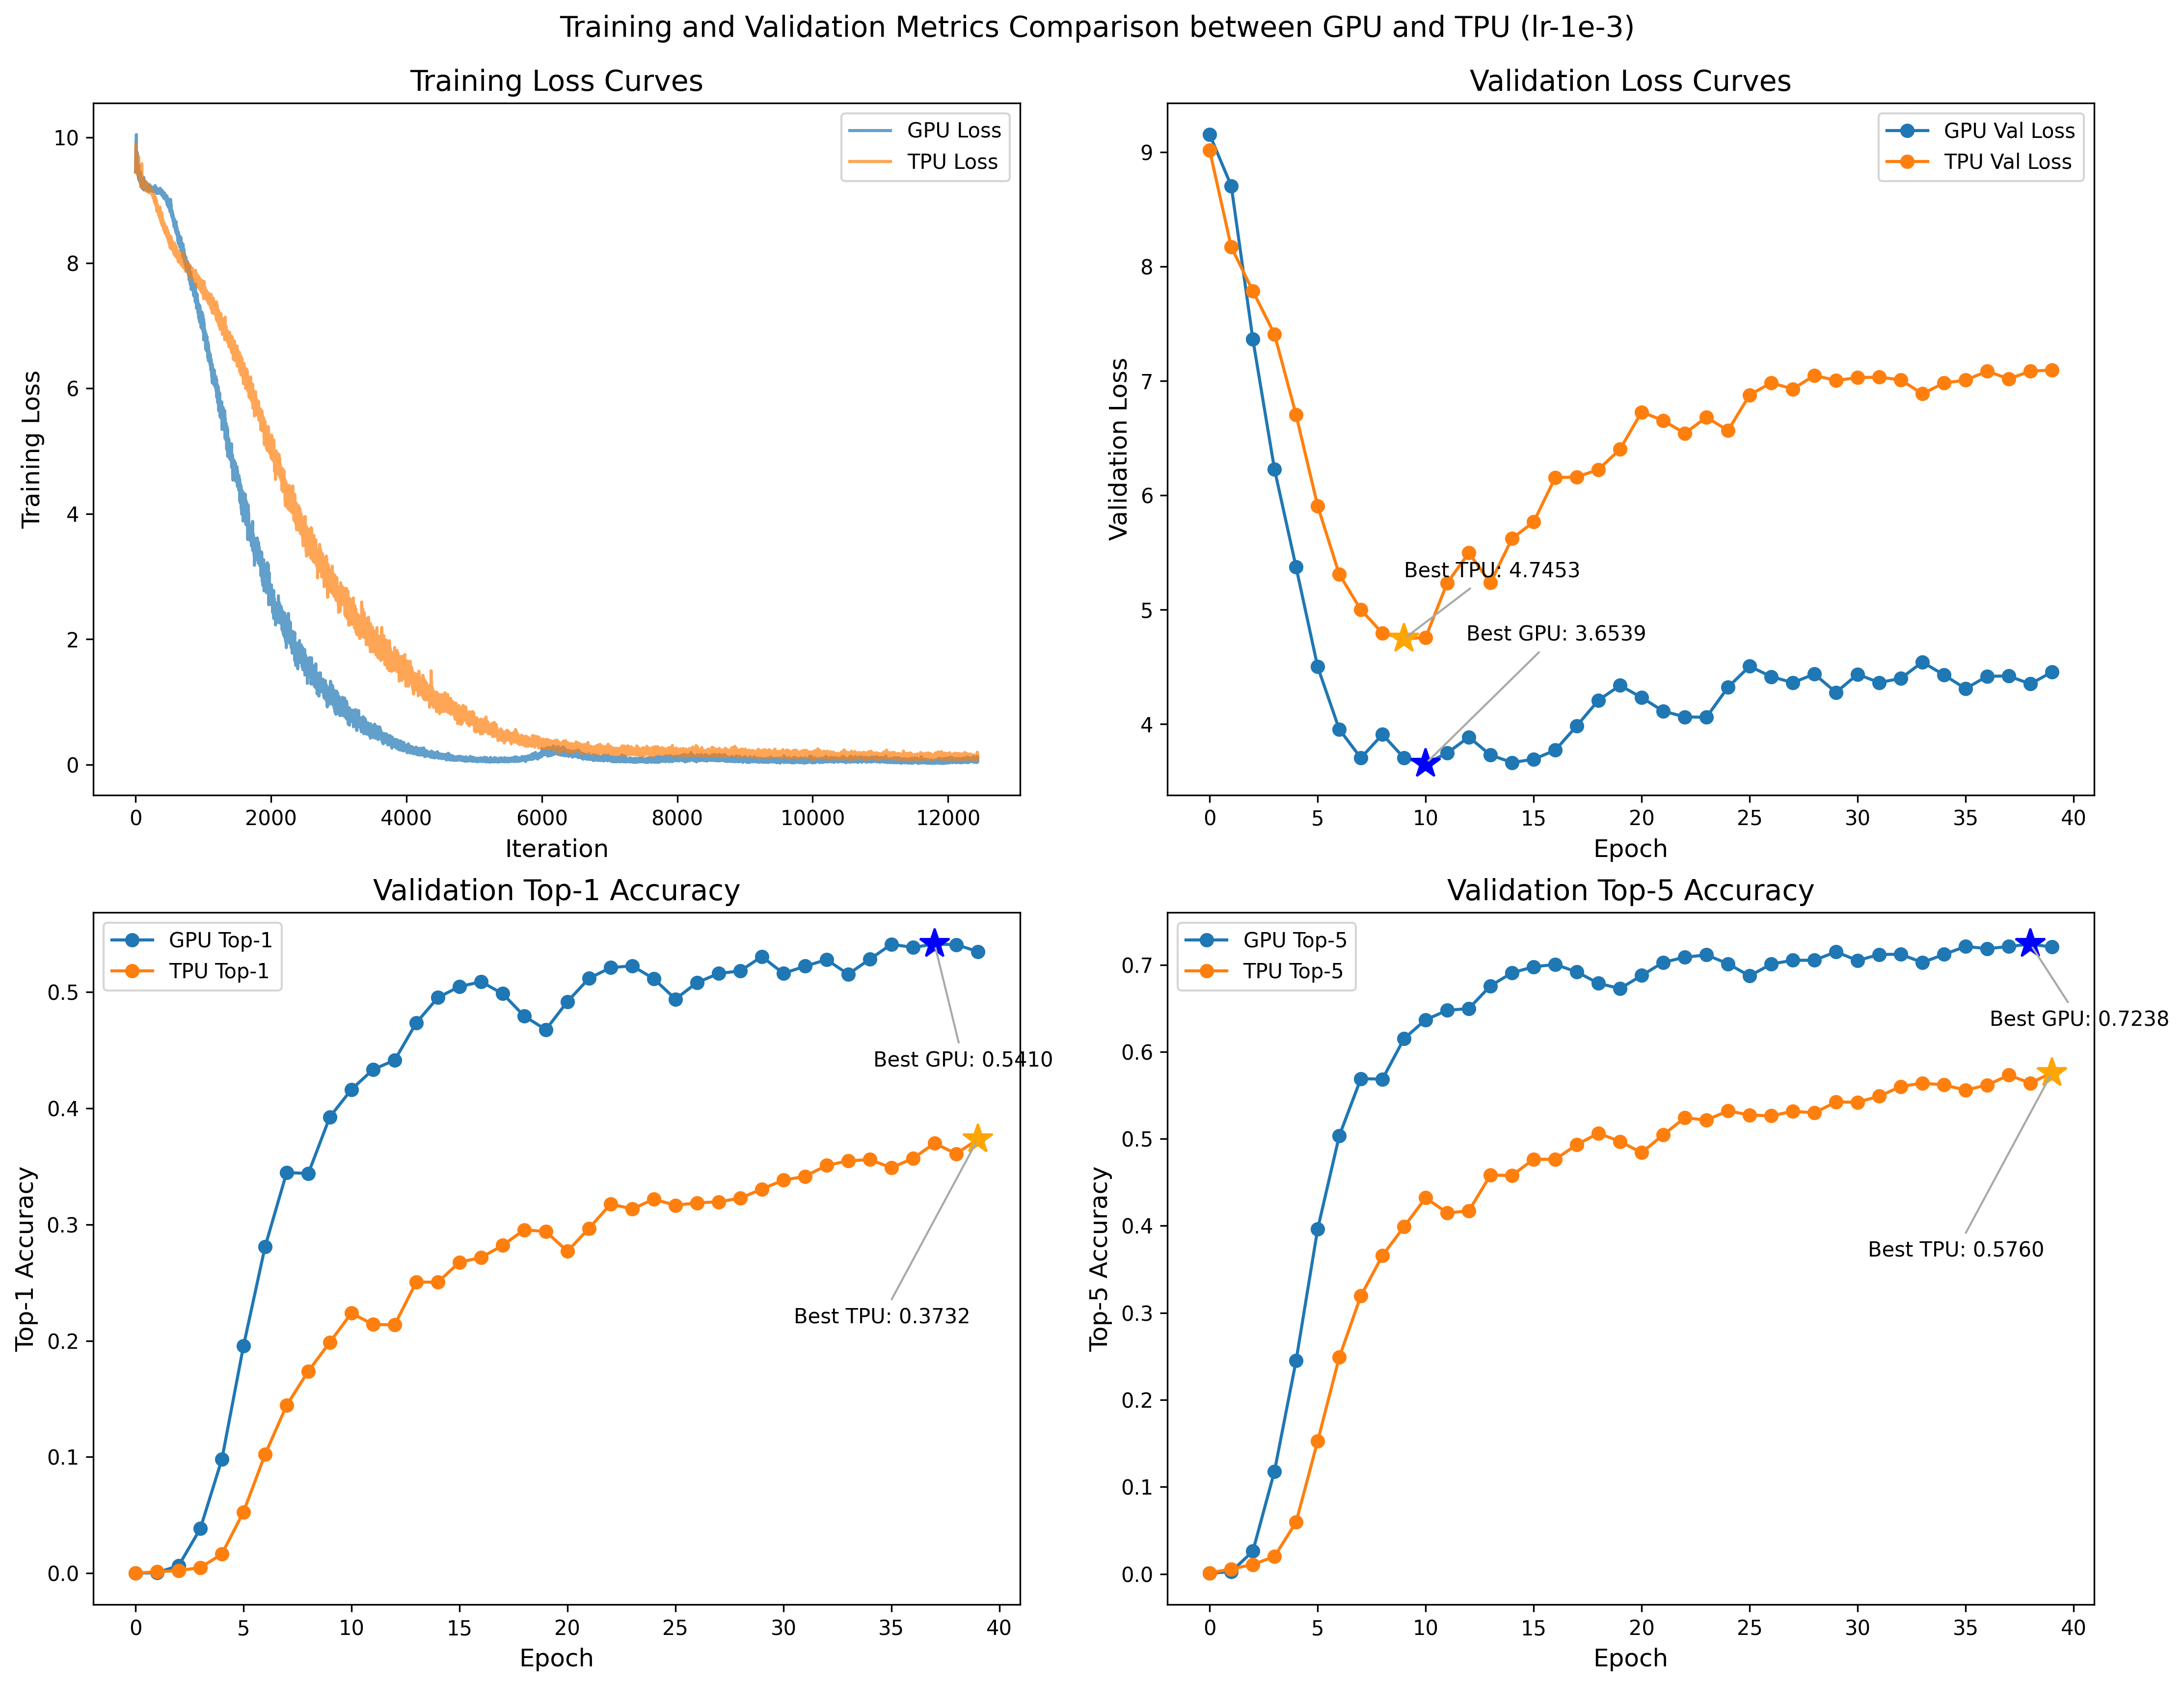

In [3]:
from metrics_util import plot_metrics, load_metrics

plot_metrics(load_metrics("lr-1e-3"), "lr-1e-3")

### Test LR=1e-4

TPU doesn't do well under learning rate `1e-4`. What happens if we reduce the
learning rate?

In [ ]:
actor_resetter = ActorResetter(gpu_actor=gpu_actor, num_classes=NUM_CLASSES, seed=42)
gpu_actor, tpu_actor = reset_all_actors(gpu_actor, tpu_actor=None, actor_resetter=actor_resetter)
ray.get(tpu_actor.set_matmul_precision.remote('default'))
ray.get(gpu_actor.init_optimizer.remote(1e-4))
ray.get(tpu_actor.init_optimizer.remote(1e-4))

BATCH_SIZE = 512
training_split = 'custom'
gpu_losses, tpu_losses, gpu_validation_metrics, tpu_validation_metrics = run_convergence_test(gpu_actor, tpu_actor, BATCH_SIZE, training_split, dataloader_seed_mixer=0)

GPU Actor (PID: 2929466) using cuda (NVIDIA A100-SXM4-80GB)
TPU Actor (PID: 2382981) using xla:0 (v5litepod-8)
✅ GPU and TPU models have identical state dicts


312it [04:32,  1.15it/s, Epoch 0 | GPU Loss: 8.654966 | TPU Loss: 8.635594 | GPU Validation: {'avg_valid_loss': 8.645389051998363, 'top1_accuracy': 0.002263906856403622, 'top5_accuracy': 0.008200887081870264} | TPU Validation: {'avg_valid_loss': 8.627612069073844, 'top1_accuracy': 0.002725928663832933, 'top5_accuracy': 0.009263537238957679}]
312it [03:47,  1.37it/s, Epoch 1 | GPU Loss: 7.689364 | TPU Loss: 7.651074 | GPU Validation: {'avg_valid_loss': 7.81246010836433, 'top1_accuracy': 0.012751801885048973, 'top5_accuracy': 0.042598410644982446} | TPU Validation: {'avg_valid_loss': 7.763554982578053, 'top1_accuracy': 0.014230271668822769, 'top5_accuracy': 0.045278137128072445}]
312it [03:42,  1.40it/s, Epoch 2 | GPU Loss: 6.767965 | TPU Loss: 6.726818 | GPU Validation: {'avg_valid_loss': 7.033754270216998, 'top1_accuracy': 0.04199778229532434, 'top5_accuracy': 0.10783588985400111} | TPU Validation: {'avg_valid_loss': 6.977119636535645, 'top1_accuracy': 0.04391517279615598, 'top5_accura

In [ ]:
from metrics_util import save_metrics

save_metrics(gpu_losses, tpu_losses, gpu_validation_metrics, tpu_validation_metrics, "lr-1e-4")

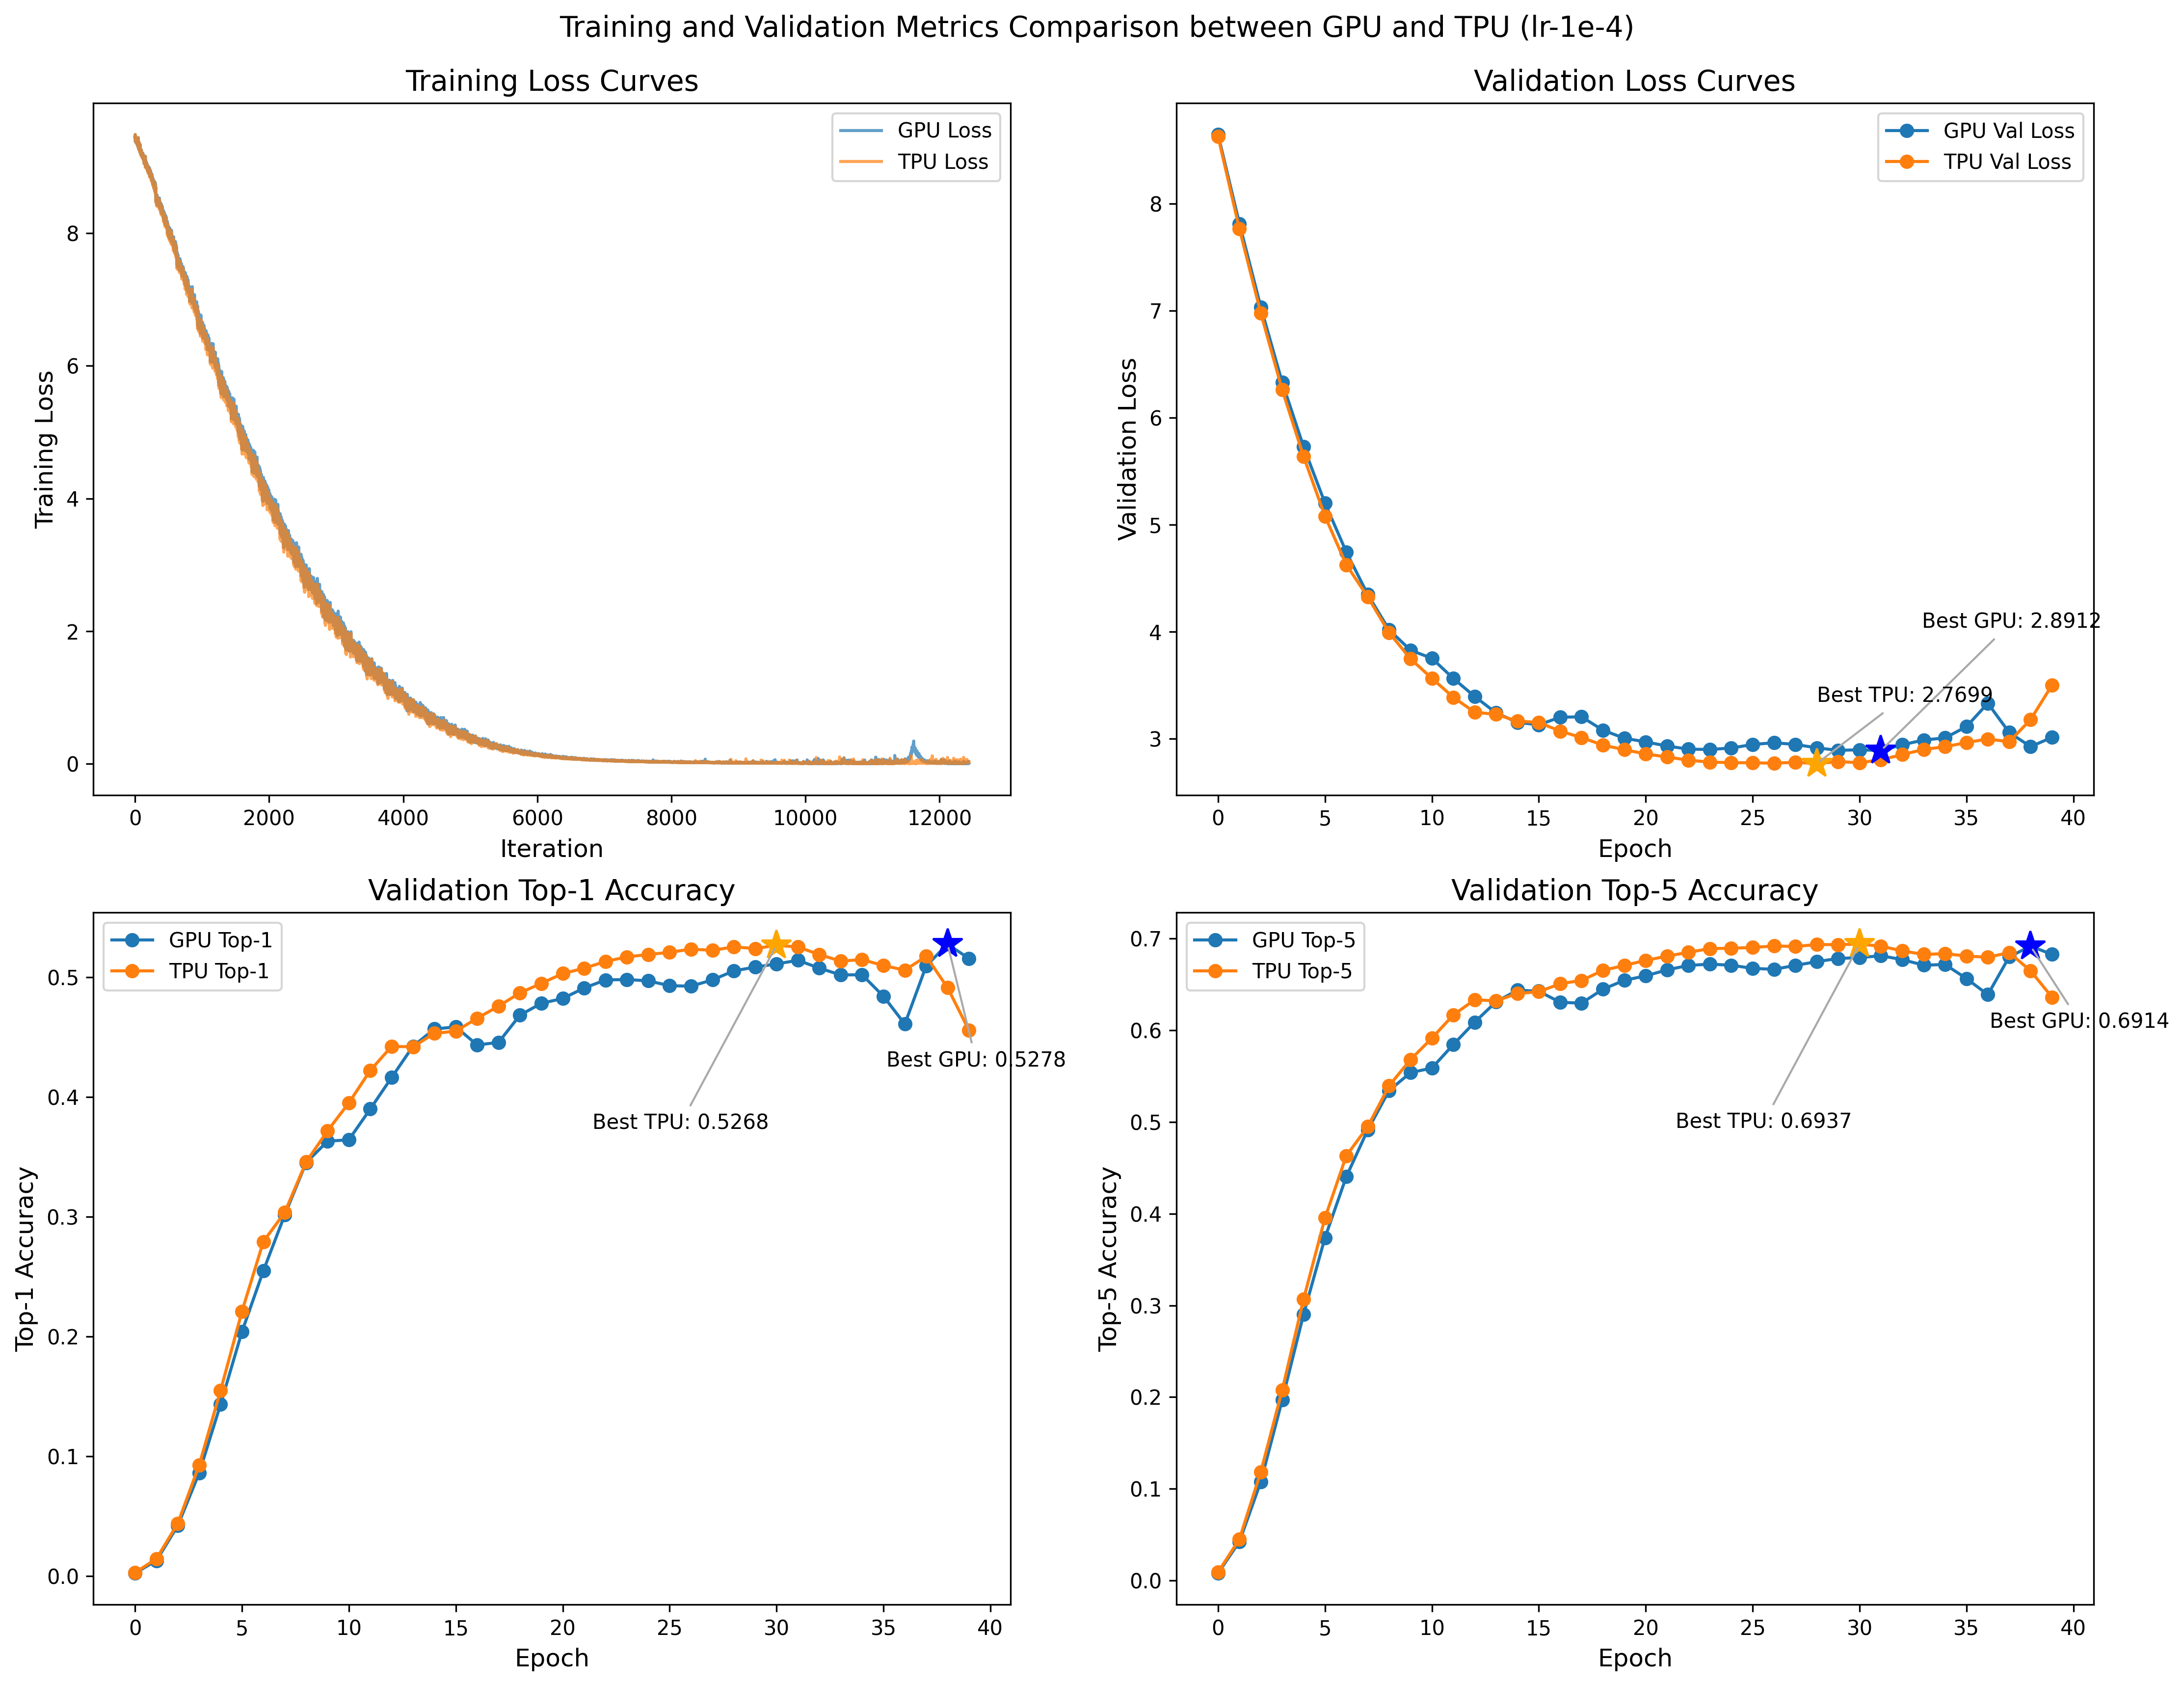

In [4]:
from metrics_util import plot_metrics, load_metrics

plot_metrics(load_metrics("lr-1e-4"), "lr-1e-4")

## Hypothesis

When the learning rate is high, the worse numerical accuracy of TPU causes issues
for the optimizer, leading reduced model accuracy.

When the learning rate is low, the gradient averaging effects of the optimizer is
able to counteract the worse numerical accuracy of TPU, leading to similar model
accuracy.

### To validate the hypothesis, let's run the training with another RNG seed (15)

GPU Actor (PID: 3142398) using cuda (NVIDIA A100-SXM4-80GB)
TPU Actor (PID: 3232709) using xla:0 (v5litepod-8)
✅ GPU and TPU models have identical state dicts


312it [04:30,  1.15it/s, Epoch 0 | GPU Loss: 9.010814 | TPU Loss: 9.198445 | GPU Validation: {'avg_valid_loss': 9.007537269592286, 'top1_accuracy': 0.00043892071705784515, 'top5_accuracy': 0.0020097948623175013} | TPU Validation: {'avg_valid_loss': 9.15553310618681, 'top1_accuracy': 0.0002079098133431898, 'top5_accuracy': 0.0008316392533727592}]
312it [03:47,  1.37it/s, Epoch 1 | GPU Loss: 8.075906 | TPU Loss: 8.918463 | GPU Validation: {'avg_valid_loss': 8.279980378992418, 'top1_accuracy': 0.0010164479763444835, 'top5_accuracy': 0.004689521345407503} | TPU Validation: {'avg_valid_loss': 9.04750565921559, 'top1_accuracy': 0.0005313250785437073, 'top5_accuracy': 0.002032895952688967}]
312it [03:46,  1.37it/s, Epoch 2 | GPU Loss: 7.419312 | TPU Loss: 7.716852 | GPU Validation: {'avg_valid_loss': 7.712008678211886, 'top1_accuracy': 0.0027490297542043986, 'top5_accuracy': 0.013791350951764923} | TPU Validation: {'avg_valid_loss': 7.940168229271384, 'top1_accuracy': 0.003303455923119571, 't

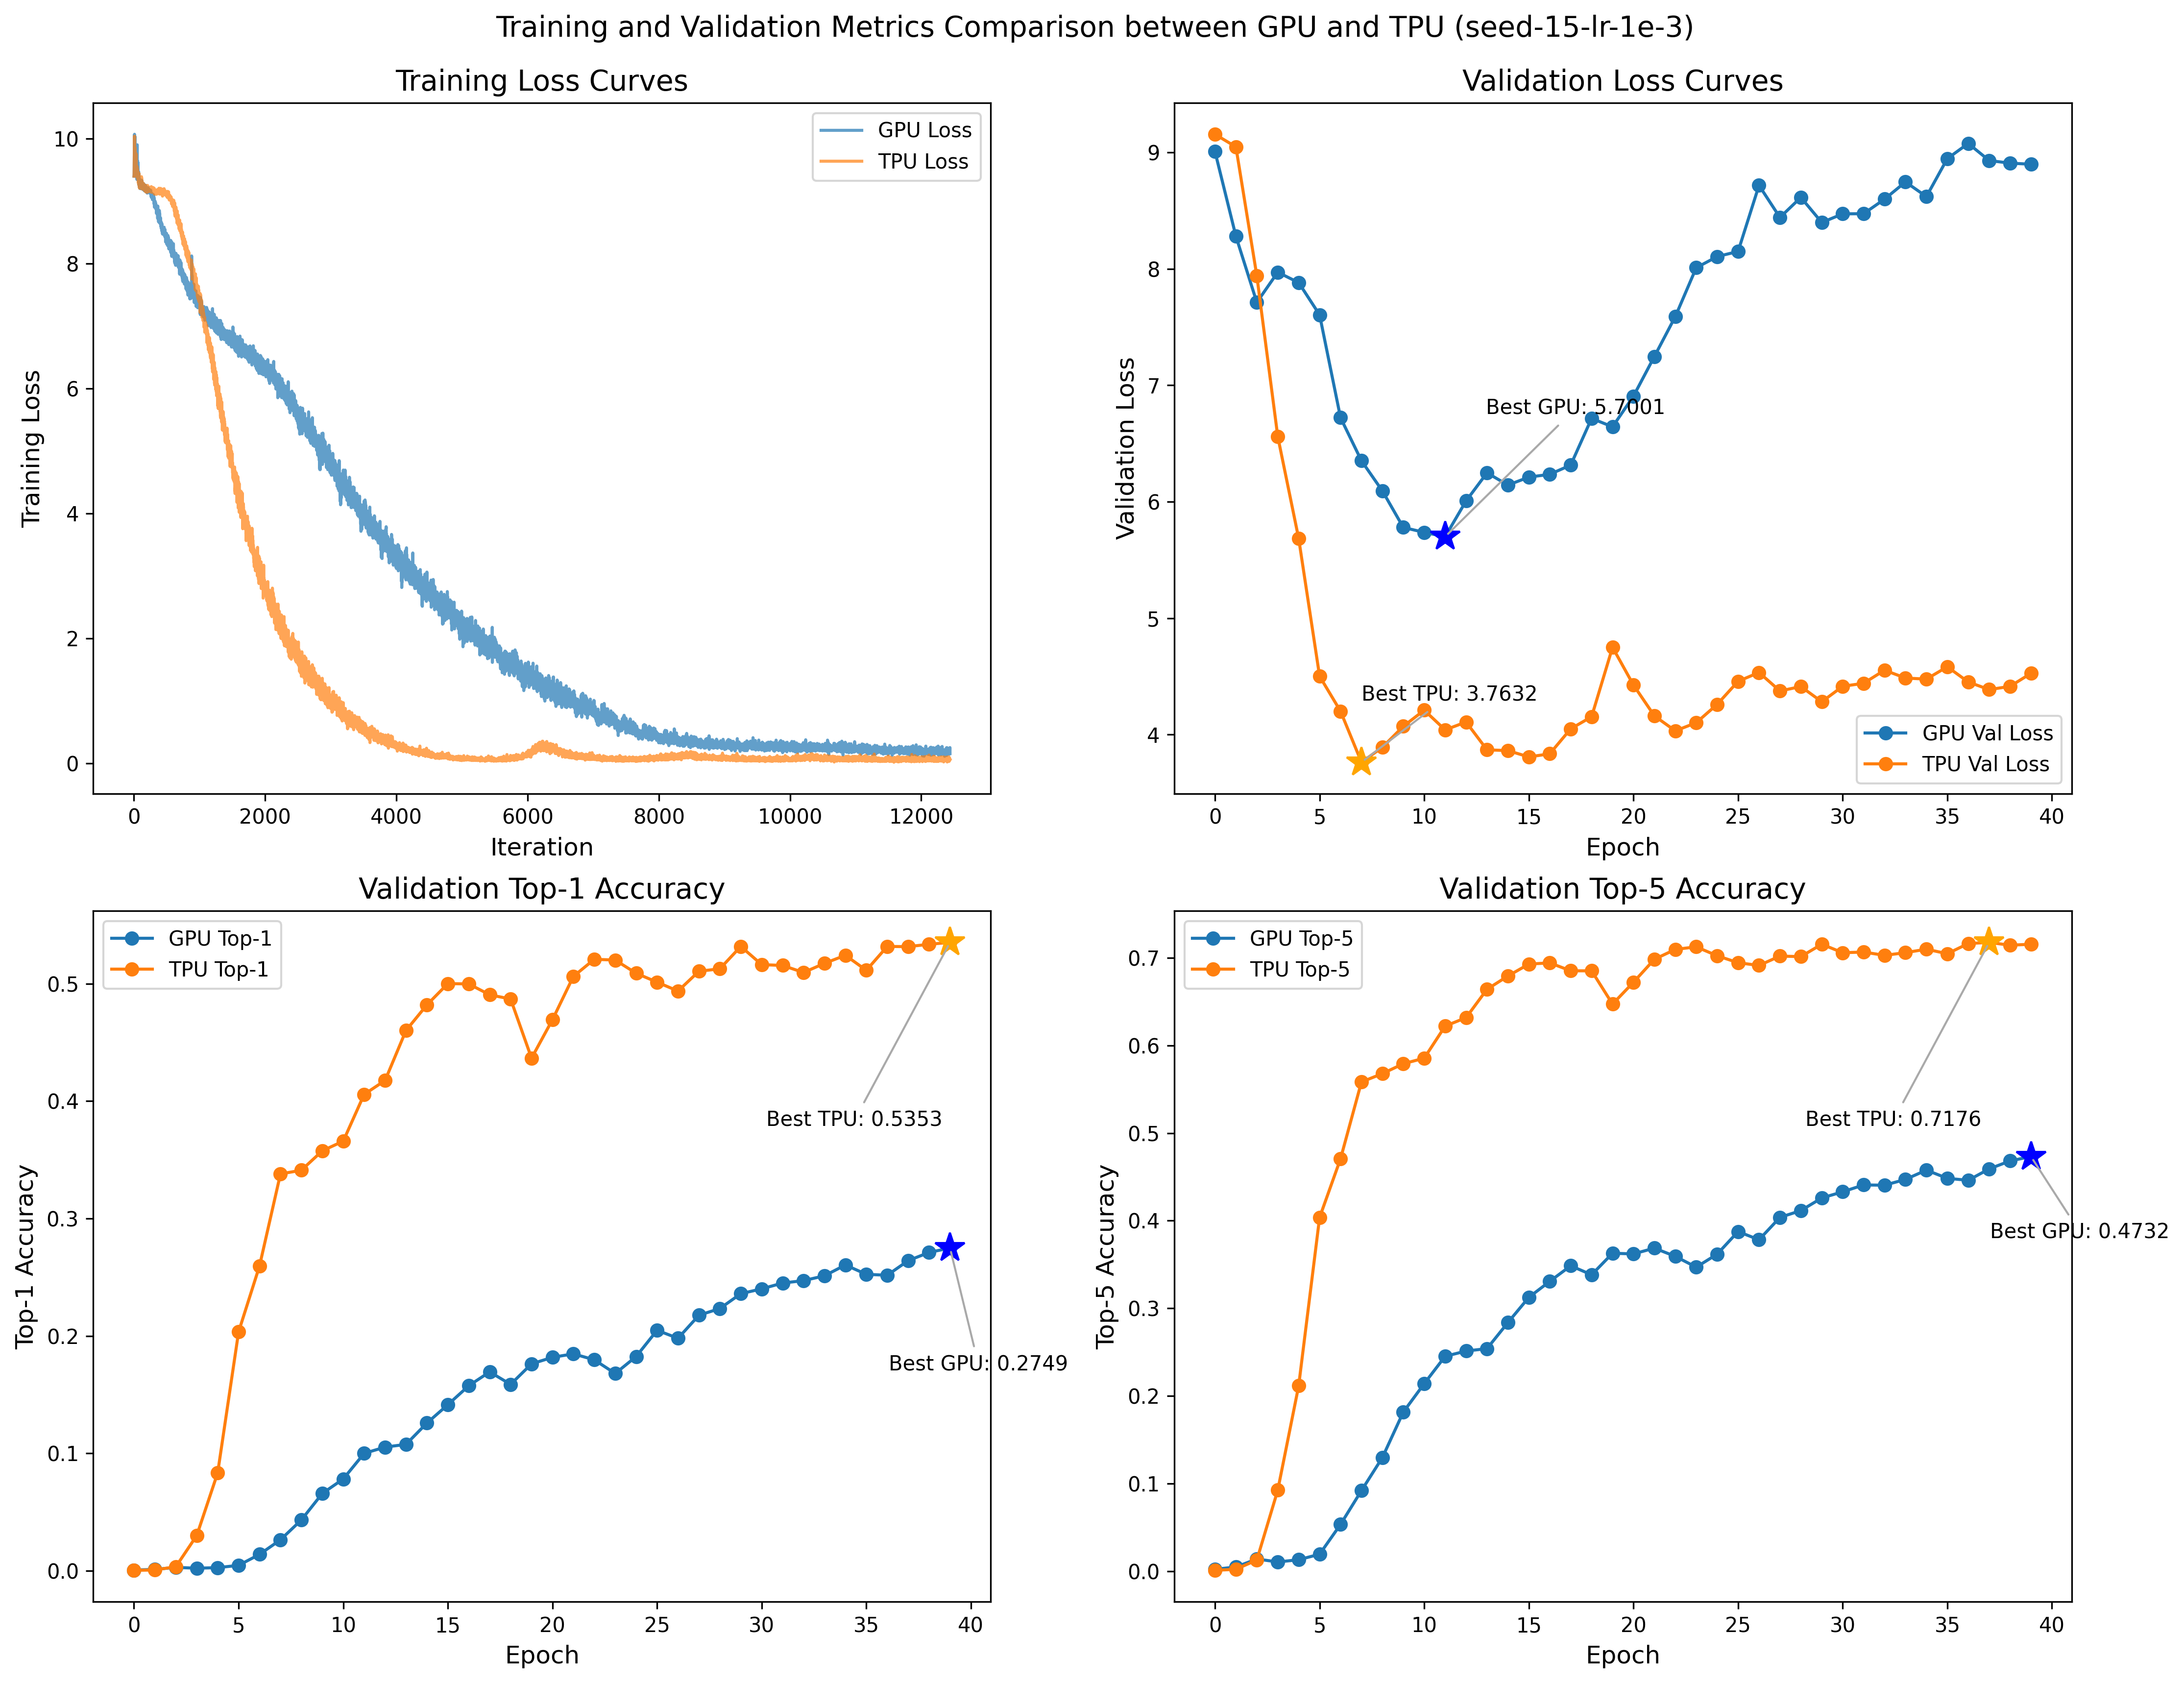

In [12]:
from actors import reset_all_actors, ActorResetter

actor_resetter = ActorResetter(gpu_actor=gpu_actor, num_classes=NUM_CLASSES, seed=15)
gpu_actor, tpu_actor = reset_all_actors(gpu_actor, tpu_actor=None, actor_resetter=actor_resetter)
ray.get(tpu_actor.set_matmul_precision.remote('default'))
ray.get(gpu_actor.init_optimizer.remote(1e-3))
ray.get(tpu_actor.init_optimizer.remote(1e-3))

BATCH_SIZE = 512
training_split = 'custom'
gpu_losses, tpu_losses, gpu_validation_metrics, tpu_validation_metrics = run_convergence_test(gpu_actor, tpu_actor, BATCH_SIZE, training_split, dataloader_seed_mixer=15)

from metrics_util import save_metrics
save_metrics(gpu_losses, tpu_losses, gpu_validation_metrics, tpu_validation_metrics, "seed-15-lr-1e-3")

from metrics_util import plot_metrics, load_metrics
plot_metrics(load_metrics("seed-15-lr-1e-3"), "seed-15-lr-1e-3")

GPU Actor (PID: 3278249) using cuda (NVIDIA A100-SXM4-80GB)
TPU Actor (PID: 3894085) using xla:0 (v5litepod-8)
✅ GPU and TPU models have identical state dicts


312it [04:19,  1.20it/s, Epoch 0 | GPU Loss: 8.720163 | TPU Loss: 8.861378 | GPU Validation: {'avg_valid_loss': 8.70046703114229, 'top1_accuracy': 0.0012705599704306042, 'top5_accuracy': 0.005451857327665866} | TPU Validation: {'avg_valid_loss': 8.836938880471623, 'top1_accuracy': 0.0012705599704306042, 'top5_accuracy': 0.004712622435778969}]
312it [03:35,  1.45it/s, Epoch 1 | GPU Loss: 7.823112 | TPU Loss: 7.907899 | GPU Validation: {'avg_valid_loss': 7.929697670656092, 'top1_accuracy': 0.008986324154500092, 'top5_accuracy': 0.029523193494732952} | TPU Validation: {'avg_valid_loss': 8.008829503900865, 'top1_accuracy': 0.00868600997967104, 'top5_accuracy': 0.028229532433930882}]
312it [03:36,  1.44it/s, Epoch 2 | GPU Loss: 6.990132 | TPU Loss: 7.033236 | GPU Validation: {'avg_valid_loss': 7.229068666345933, 'top1_accuracy': 0.03010072075401959, 'top5_accuracy': 0.08129273701718721} | TPU Validation: {'avg_valid_loss': 7.261845942104564, 'top1_accuracy': 0.029569395675475882, 'top5_accu

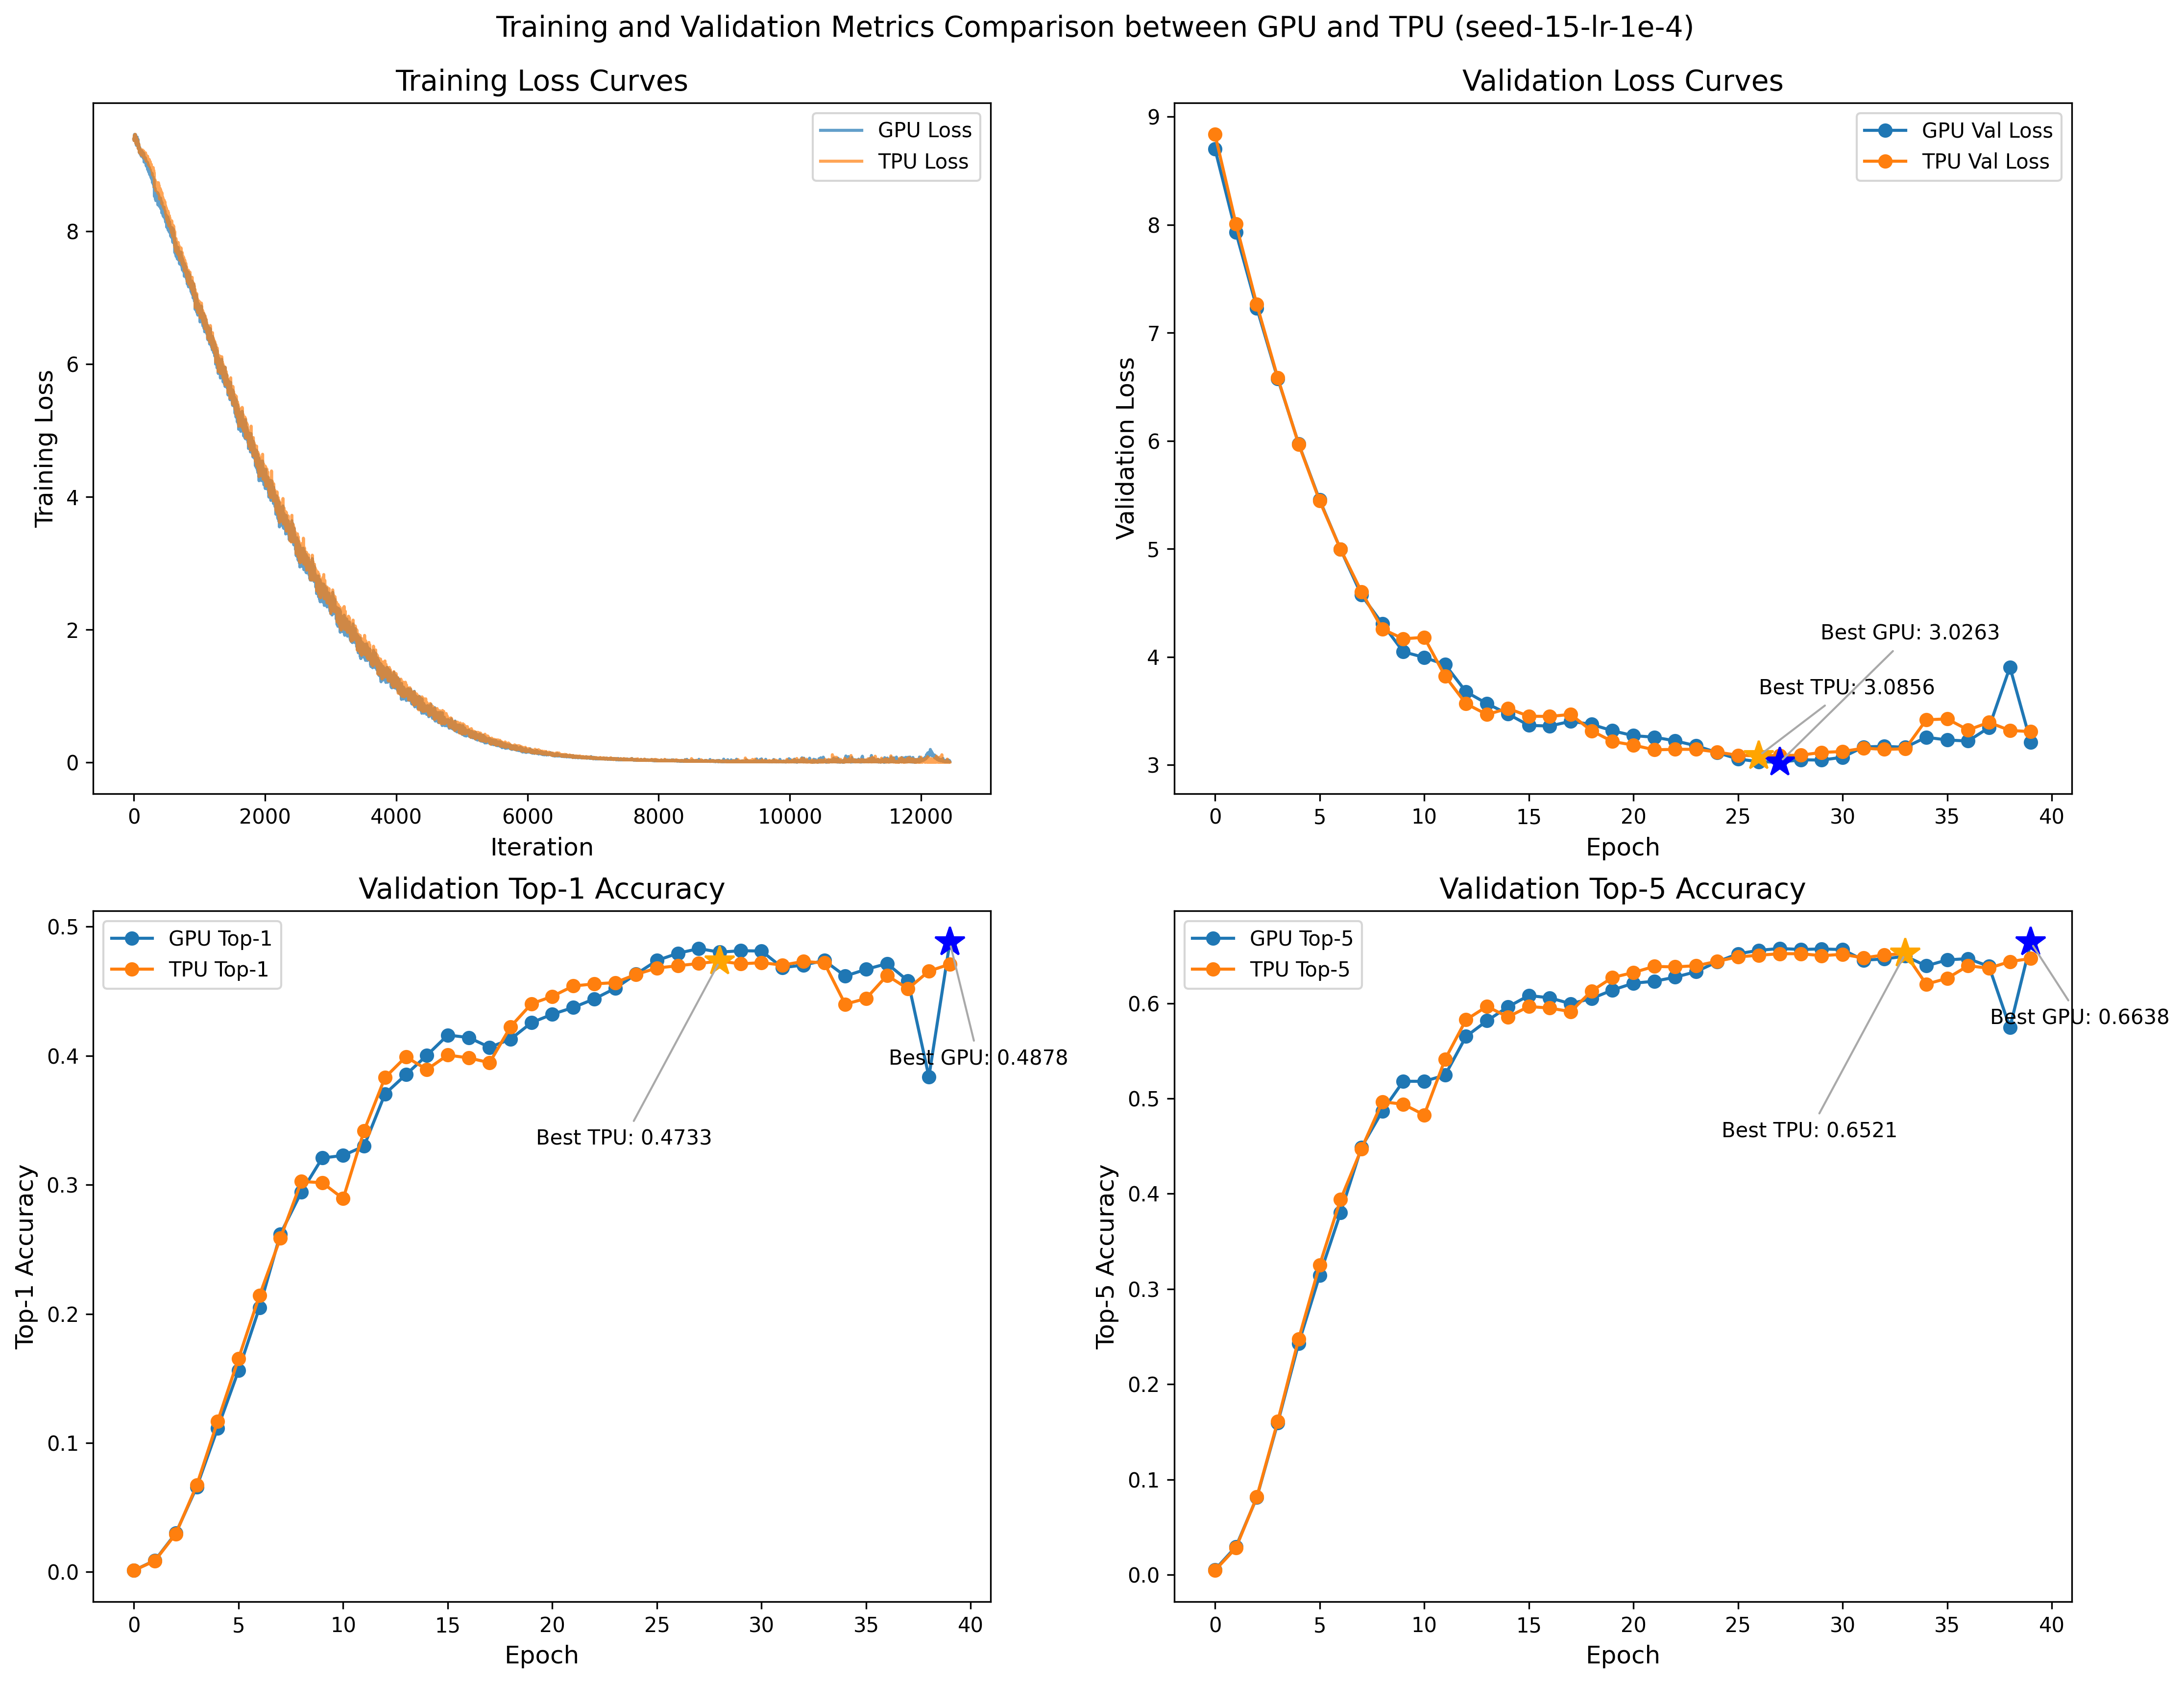

In [13]:
from actors import reset_all_actors, ActorResetter

actor_resetter = ActorResetter(gpu_actor=gpu_actor, num_classes=NUM_CLASSES, seed=15)
gpu_actor, tpu_actor = reset_all_actors(gpu_actor, tpu_actor=None, actor_resetter=actor_resetter)
ray.get(tpu_actor.set_matmul_precision.remote('default'))
ray.get(gpu_actor.init_optimizer.remote(1e-4))
ray.get(tpu_actor.init_optimizer.remote(1e-4))

BATCH_SIZE = 512
training_split = 'custom'
gpu_losses, tpu_losses, gpu_validation_metrics, tpu_validation_metrics = run_convergence_test(gpu_actor, tpu_actor, BATCH_SIZE, training_split, dataloader_seed_mixer=15)

from metrics_util import save_metrics
save_metrics(gpu_losses, tpu_losses, gpu_validation_metrics, tpu_validation_metrics, "seed-15-lr-1e-4")

from metrics_util import plot_metrics, load_metrics
plot_metrics(load_metrics("seed-15-lr-1e-4"), "seed-15-lr-1e-4")

### To further validate the hypothesis, let's run the training with increased accuracy

In [ ]:
from actors import reset_all_actors, ActorResetter

actor_resetter = ActorResetter(gpu_actor=gpu_actor, num_classes=NUM_CLASSES, seed=42)
gpu_actor, tpu_actor = reset_all_actors(gpu_actor, tpu_actor=None, actor_resetter=actor_resetter)
ray.get(tpu_actor.set_matmul_precision.remote('high'))
ray.get(gpu_actor.init_optimizer.remote(1e-3))
ray.get(tpu_actor.init_optimizer.remote(1e-3))

BATCH_SIZE = 512
training_split = 'custom'
gpu_losses, tpu_losses, gpu_validation_metrics, tpu_validation_metrics = run_convergence_test(gpu_actor, tpu_actor, BATCH_SIZE, training_split, dataloader_seed_mixer=0)

from metrics_util import save_metrics
save_metrics(gpu_losses, tpu_losses, gpu_validation_metrics, tpu_validation_metrics, "high-precision-lr-1e-3")

from metrics_util import plot_metrics, load_metrics
plot_metrics(load_metrics("high-precision-lr-1e-3"), "high-precision-lr-1e-3")

GPU Actor (PID: 3417763) using cuda (NVIDIA A100-SXM4-80GB)
TPU Actor (PID: 385284) using xla:0 (v5litepod-8)
✅ GPU and TPU models have identical state dicts


312it [05:37,  1.08s/it, Epoch 0 | GPU Loss: 8.845392 | TPU Loss: 9.193377 | GPU Validation: {'avg_valid_loss': 9.338443385853488, 'top1_accuracy': 0.0002079098133431898, 'top5_accuracy': 0.001131953428201811} | TPU Validation: {'avg_valid_loss': 9.151763411129222, 'top1_accuracy': 0.0001386065422287932, 'top5_accuracy': 0.000693032711143966}]
280it [02:44,  2.36it/s, Epoch 1 Iter 279 | GPU Loss: 7.959858 | TPU Loss: 8.641954]

In [ ]:
from actors import reset_all_actors, ActorResetter

actor_resetter = ActorResetter(gpu_actor=gpu_actor, num_classes=NUM_CLASSES, seed=42)
gpu_actor, tpu_actor = reset_all_actors(gpu_actor, tpu_actor=None, actor_resetter=actor_resetter)
ray.get(tpu_actor.set_matmul_precision.remote('high'))
ray.get(gpu_actor.init_optimizer.remote(1e-4))
ray.get(tpu_actor.init_optimizer.remote(1e-4))

BATCH_SIZE = 512
training_split = 'custom'
gpu_losses, tpu_losses, gpu_validation_metrics, tpu_validation_metrics = run_convergence_test(gpu_actor, tpu_actor, BATCH_SIZE, training_split, dataloader_seed_mixer=0)

from metrics_util import save_metrics
save_metrics(gpu_losses, tpu_losses, gpu_validation_metrics, tpu_validation_metrics, "high-precision-lr-1e-4")

from metrics_util import plot_metrics, load_metrics
plot_metrics(load_metrics("high-precision-lr-1e-4"), "high-precision-lr-1e-4")